### ライブラリインポート

In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

from scipy.stats import binom

import pymc as pm
import arviz as az

## 11.1 例題:一次元空間上の個体数分布

In [2]:
data = pl.read_parquet("../data/ch 11/Y.parquet").to_pandas()
data

,Y,m,j
0,0.0,2.154980,1
1,3.0,3.254165,2
2,2.0,4.628666,3
3,5.0,6.234124,4
4,6.0,7.990730,5
5,16.0,9.794474,6
6,8.0,11.533365,7
7,14.0,13.104252,8
8,11.0,14.426302,9
9,10.0,15.448779,10


<Axes: xlabel='j', ylabel='Y'>

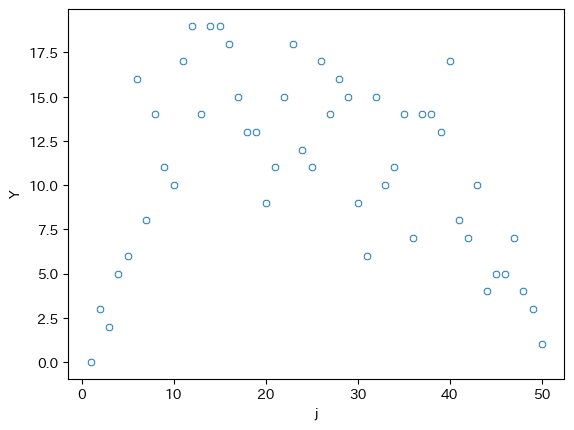

In [3]:
sns.scatterplot(data = data, x = "j", y = "Y", marker = "$\circ$")

### 11.2.1 空間構造の無い階層事前分布

### 11.2.2 空間構造のある階層事前分布

## 11.3 空間統計モデルをデータにあてはめる

#### 確率モデル定義

In [12]:
# 空間統計モデル（CAR model）をpymc3で。（緑本11章） - gaiaskyの技術メモ
# https://gaiasky.hatenablog.com/entry/2018/08/15/205222

# 隣接情報
adj = np.array(
       [[1], [0, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7], [6, 8], [7, 9],
       [8, 10], [9, 11], [10, 12], [11, 13], [12, 14], [13, 15], [14, 16],
       [15, 17], [16, 18], [17, 19], [18, 20], [19, 21], [20, 22],
       [21, 23], [22, 24], [23, 25], [24, 26], [25, 27], [26, 28],
       [27, 29], [28, 30], [29, 31], [30, 32], [31, 33], [32, 34],
       [33, 35], [34, 36], [35, 37], [36, 38], [37, 39], [38, 40],
       [39, 41], [40, 42], [41, 43], [42, 44], [43, 45], [44, 46],
       [45, 47], [46, 48], [47, 49], [49]], dtype=object)

# 重み
weights = np.array(
       [[1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0, 1.0],
       [1.0, 1.0], [1.0, 1.0], [1.0, 1.0], [1.0]], dtype=object)

# 上記の重みをPyMC作例を基に修正する
# Conditional Autoregressive (CAR) Models for Spatial Data — PyMC example gallery
# https://www.pymc.io/projects/examples/en/latest/spatial/conditional_autoregressive_priors.html

df_adj = (
    pl.DataFrame([
        pl.Series("ADJ", adj),
        pl.Series("WEIGHTS", weights)
    ]).to_pandas()
)

# spatial adjacency information: column `ADJ` contains list entries which are preprocessed to obtain adj as a list of lists
adj = (
    df_adj["ADJ"].to_list()
)

# change to Python indexing (i.e. -1)
#for i in range(len(adj)):
#    for j in range(len(adj[i])):
#        adj[i][j] = adj[i][j] - 1

# sample quantity
N = len(df_adj)

# storing the adjacency matrix as a two-dimensional np.array
adj_matrix = np.zeros((N, N), dtype="int32")

for area in range(N):
    adj_matrix[area, adj[area]] = 1

In [13]:
model1 = pm.Model(coords={"area_idx": data["j"].to_numpy()})

with model1:
    # 観測値
    Y_j = pm.ConstantData('Y_j', data["Y"].to_numpy())
    #j = pm.ConstantData("j", data["j"].to_numpy())

    # 無情報事前分布
    s = pm.Uniform(name = "s", lower = 0, upper = 1e4)
    tau = 1 / s * s
    # 場所差
    r_i = pm.CAR(name = "r_i", mu = np.zeros(N), W = adj_matrix, alpha= 0.95, tau = tau, dims="area_idx")
    # 全地点共通
    beta = pm.Normal(name = "beta", mu = 0, sigma = 1e2)

    # パラメータ
    mean_j = pm.math.exp(beta + r_i)

    # ポアソン分布
    Y_obs = pm.Poisson(name = "poisson", mu = mean_j, observed = Y_j)

#### 確率モデル構造可視化

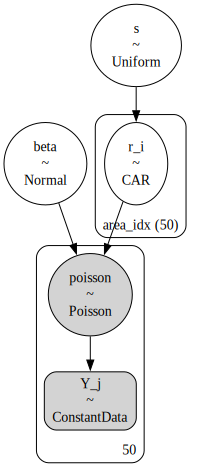

In [14]:
g = pm.model_to_graphviz(model1)
display(g)

#### サンプリング

In [15]:
with model1:
    idata1 = pm.sample(random_seed = 42, chains = 5, tune = 5, draws = 5)# , chains = 5, tune = 5, draws = 5

Only 5 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


AssertionError: W must be a symmetric adjacency matrix.
Apply node that caused the error: Assert{msg=W must be a symmetric adjacency matrix.}([[0 1 0 .. ... .. 0 0 1]], All{axes=None}.0)
Toposort index: 11
Inputs types: [TensorType(int32, shape=(50, 50)), TensorType(bool, shape=())]
Inputs shapes: [(50, 50), ()]
Inputs strides: [(200, 4), ()]
Inputs values: ['not shown', array(False)]
Outputs clients: [[Transpose{axes=[1, 0]}(Assert{msg=W must be a symmetric adjacency matrix.}.0), Sign(Assert{msg=W must be a symmetric adjacency matrix.}.0), Shape(Assert{msg=W must be a symmetric adjacency matrix.}.0), Shape(Assert{msg=W must be a symmetric adjacency matrix.}.0), Shape(Assert{msg=W must be a symmetric adjacency matrix.}.0), Shape(Assert{msg=W must be a symmetric adjacency matrix.}.0), Sub(Assert{msg=W must be a symmetric adjacency matrix.}.0, Transpose{axes=[1, 0]}.0), Assert{msg=W must be a symmetric adjacency matrix.}(Assert{msg=W must be a symmetric adjacency matrix.}.0, All{axes=None}.0)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\distributions\distribution.py", line 411, in __new__
    rv_out = cls.dist(*args, **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\distributions\multivariate.py", line 2244, in dist
    return super().dist([mu, W, alpha, tau], **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\distributions\distribution.py", line 490, in dist
    rv_out = cls.rv_op(*dist_params, size=create_size, **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pytensor\tensor\random\op.py", line 239, in __call__
    res = super().__call__(rng, size, dtype, *args, **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pytensor\graph\op.py", line 295, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pymc\distributions\multivariate.py", line 2133, in make_node
    W = Assert(msg)(W, pt.allclose(W, W.T))
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pytensor\graph\op.py", line 295, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "c:\Users\treme\.conda\envs\pymc_env\Lib\site-packages\pytensor\raise_op.py", line 91, in make_node
    [value.type()],

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

#### plot_trace 関数呼び出し

In [ ]:
az.plot_trace(idata1, compact = False, var_names = ["s", "r_i", "beta"])
plt.tight_layout()